# Importing libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F


Working with CUDA capabilities.

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

True
1
0
GeForce RTX 2080 with Max-Q Design


# Loading the train data set

In [3]:
data_dir = '../../Images/june5Night/Positive/'      #This is for the home laptop
# data_dir = '../../../../BottleStoodUp_atNight/Positive/'        #For the work laptop

In [4]:
transform_characteristics = transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize(255),
                                                transforms.CenterCrop(224)])
dataset = datasets.ImageFolder(data_dir, transform=transform_characteristics)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=15, shuffle=True)

We see 20 batches of 15 images each. Becasue we have in total 295 of positive images.

In [5]:
print(len(dataloader))

20


In [6]:
images, labels = next(iter(dataloader))
print("The images are stored in a variable of type: ", type(images))
print("The classes labels are: ", labels)
print(torch.min(images), torch.max(images))

c:\Users\alexj\.conda\envs\tfm_3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


The images are stored in a variable of type:  <class 'torch.Tensor'>
The classes labels are:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor(0.0006) tensor(1.)


# Showing one sample of the training set images

Grabbing only one image of the training set, permuting its shape sizes and converting to numpy to able to display it.

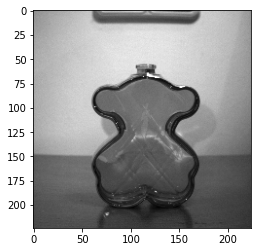

In [7]:
single_img = images[0]
single_img_permuted = single_img.permute(1, 2, 0) 
single_img_numpy = single_img_permuted.detach().numpy()

plt.imshow(single_img_numpy)

Now, cropping the image to be of size 160x160.

In [8]:
TOP_CROP_POS = 50
LEFT_CROP_POS = 35

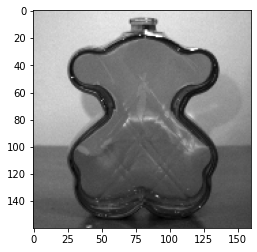

In [9]:
imgs_croped = transforms.functional.crop(images, TOP_CROP_POS, LEFT_CROP_POS, 160, 160)
single_img = imgs_croped[0]
single_img_permuted = single_img.permute(1, 2, 0) 
single_img_numpy = single_img_permuted.cpu().detach().numpy()

plt.imshow(single_img_numpy)

# Building the model Autoencoder model

In [10]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # 15, 3, 160, 160.  Batch size, input channels, shape of the image.
        input_channels = 3              # number of channels of the input image
        output_channels = 55           # ~= 110/2. Shape of the input image divided by 2 approximately. 
        kernel_size = 9
        padding_val = 1
        stride_val = 5

        output_channels_layer2 = output_channels*2+5
        output_channels_layer3 = output_channels_layer2*2
        
        self.conv2d_1 = nn.Conv2d(input_channels, output_channels, kernel_size, stride=stride_val, padding=padding_val)
        self.conv2d_2 = nn.Conv2d(output_channels, output_channels_layer2, kernel_size, stride=stride_val, padding=padding_val)
        self.conv2d_3 = nn.Conv2d(output_channels_layer2, output_channels_layer3, 5)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()

        # self.fc = nn.Linear(output_channels_layer3, output_channels_layer3)
        # self.encoder_tanh = nn.Tanh()
        # self.decoder_tanh = nn.Tanh()
        # self.decoder_fc = nn.Linear(output_channels_layer3, output_channels_layer3)

        self.convTranspose2d_1 = nn.ConvTranspose2d(output_channels_layer3, output_channels_layer2, 5)
        self.convTranspose2d_2 = nn.ConvTranspose2d(output_channels_layer2, output_channels, kernel_size, stride=stride_val, padding=padding_val, output_padding=4)
        self.convTranspose2d_3 = nn.ConvTranspose2d(output_channels, input_channels, kernel_size, stride=stride_val, padding=padding_val, output_padding=3)
        self.relu3 = nn.ReLU()
        self.relu4 = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, flag = False):
        if flag:
            print("The FORWARD function is starting")

            print("The ENCODER part is executing")
            output = x
            print("The input image shape is: ", output.shape)
            output = self.conv2d_1(output)
            print("self.conv2d_1 shape is: ", output.shape)
            output = self.relu1(output)
            output = self.conv2d_2(output)
            print("self.conv2d_2 shape is: ", output.shape)
            output = self.relu2(output)
            output = self.conv2d_3(output)
            print("self.conv2d_3 shape is: ", output.shape)

            # print("The LINEAR and TANH layers")
            # output = output.view(output.size(0), -1)
            # print("output.view shape is: ", output.shape)
            # output = self.fc(output)
            # print("self.fc shape is: ", output.shape)
            # output = self.encoder_tanh(output)
            # print("self.encoder_tanh shape is: ", output.shape)

            # output = self.decoder_tanh(output)
            # print("self.decoder_tanh shape is: ", output.shape)
            # output = self.decoder_fc(output)
            # print("self.decoder_fc shape is: ", output.shape)
            # output = output.view(-1, output.size(1), 1, 1)
            # print("output.view shape is: ", output.shape)
            

            print("The DECODER part is executing")
            output = self.convTranspose2d_1(output)
            print("self.convTranspose2d_1 shape is: ", output.shape)
            output = self.relu3(output)
            output = self.convTranspose2d_2(output)
            print("self.convTranspose2d_2 shape is: ", output.shape)
            output = self.relu4(output)
            output = self.convTranspose2d_3(output)
            print("self.convTranspose2d_3 shape is: ", output.shape)
            output = self.sigmoid(output)
            print("self.sigmoid shape is: ", output.shape)

            print("Finish the FORWARD function")
        else:
             # print("The FORWARD function is starting")

            # print("The ENCODER part is executing")
            output = x
            # print("The input image shape is: ", output.shape)
            output = self.conv2d_1(output)
            # print("self.conv2d_1 shape is: ", output.shape)
            output = self.relu1(output)
            output = self.conv2d_2(output)
            # print("self.conv2d_2 shape is: ", output.shape)
            output = self.relu2(output)
            output = self.conv2d_3(output)
            # print("self.conv2d_3 shape is: ", output.shape)

            # # print("The LINEAR and TANH layers")
            # output = output.view(output.size(0), -1)
            # # print("output.view shape is: ", output.shape)
            # output = self.fc(output)
            # # print("self.fc shape is: ", output.shape)
            # output = self.encoder_tanh(output)
            # # print("self.encoder_tanh shape is: ", output.shape)

            # output = self.decoder_tanh(output)
            # # print("self.decoder_tanh shape is: ", output.shape)
            # output = self.decoder_fc(output)
            # # print("self.decoder_fc shape is: ", output.shape)
            # output = output.view(-1, output.size(1), 1, 1)
            # # print("output.view shape is: ", output.shape)
            

            # print("The DECODER part is executing")
            output = self.convTranspose2d_1(output)
            # print("self.convTranspose2d_1 shape is: ", output.shape)
            output = self.relu3(output)
            output = self.convTranspose2d_2(output)
            # print("self.convTranspose2d_2 shape is: ", output.shape)
            output = self.relu4(output)
            output = self.convTranspose2d_3(output)
            # print("self.convTranspose2d_3 shape is: ", output.shape)
            output = self.sigmoid(output)
            # print("self.sigmoid shape is: ", output.shape)

            # print("Finish the FORWARD function")
        return output
    
    def show_one_layer_weights(self, index):
        print("This is the one layer show function")
        i = 0
        for name, m in self.named_modules():
        # for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
                if i == index:
                    print("Layer name is:", name)
                    print("The weights are: ", m.weight)
                i = i +1   
 
# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

Making sure to use the GPU for the trainig stage

In [11]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)

cuda:0


In [12]:
model = Autoencoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-4)
model.to(device)

Autoencoder(
  (conv2d_1): Conv2d(3, 55, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
  (conv2d_2): Conv2d(55, 115, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
  (conv2d_3): Conv2d(115, 230, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (relu2): ReLU()
  (convTranspose2d_1): ConvTranspose2d(230, 115, kernel_size=(5, 5), stride=(1, 1))
  (convTranspose2d_2): ConvTranspose2d(115, 55, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(4, 4))
  (convTranspose2d_3): ConvTranspose2d(55, 3, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(3, 3))
  (relu3): ReLU()
  (relu4): ReLU()
  (sigmoid): Sigmoid()
)

In [13]:
torch.cuda.empty_cache()

# Training the model

In [14]:
val_dir_for_training = '../../Images/june5Night/Positive_val'      #This is for the home laptop

transform_characteristics = transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize(255),
                                                transforms.CenterCrop(224)])

dataset_val_for_training = datasets.ImageFolder(val_dir_for_training, transform=transform_characteristics)
dataloader_val_for_training = torch.utils.data.DataLoader(dataset_val_for_training, batch_size=15, shuffle=True)
print(len(dataloader_val_for_training))

2


Actually training the model with early stopping and storing the loss function values accross all epochs.

In [15]:
# epochs_toCheck_earlyStopping = 10
# min_diff_earlyStopping = 0.0005
# # Point to training loop video
# num_epochs = 300
# outputs = []
# prev_losses = [float('inf')] * epochs_toCheck_earlyStopping  # Initialize previous losses with infinity
# losses_list = []
# losses_avg_list = []

# losses_val_list = []
# losses_val_avg_list = []

# for epoch in range(num_epochs):
#     for (img, _) in dataloader:     # This iterates over the batches of images.
#         img = img.to(device)
#         # Forward pass
#         recon = model(img)          # The entire batch of images is passed to the model
#         loss = criterion(recon, img)

#         # Backward and optimize
#         optimizer.zero_grad()       # Sets the gradients of all optimized torch.Tensors to zero
#         loss.backward()             # The accumulation (or sum) of all the gradients is calculated     
#         optimizer.step()            # can be called once the gradients are computed 
#         losses_list.append(loss.item())  

#     for (img, _) in dataloader_val_for_training:     # This iterates over the batches of images.
#         img = img.to(device)
#         # Forward pass
#         recon_val = model(img.cuda())          # The entire batch of images is passed to the model
#         losses_val = criterion(recon_val, img)
#         losses_val_list.append(losses_val.item())

#     loss_avg_epoch = np.mean(losses_list[-len(dataloader):])
#     losses_avg_list.append(loss_avg_epoch)
    
#     loss_val_avg_epoch = np.mean(losses_val_list[-len(dataloader_val_for_training):])
#     losses_val_avg_list.append(loss_val_avg_epoch)

#     print(f'Epoch:{epoch+1}, average training loss:{loss_avg_epoch:.4f}, average validation loss:{loss_val_avg_epoch:.4f}')

#     # Append the current validation loss to the previous losses list
#     prev_losses.append(loss_val_avg_epoch)
#     prev_losses = prev_losses[-epochs_toCheck_earlyStopping:]  # Keep only the last 10 losses
#     # print(prev_losses)
#     # Check if the last 10 losses are the same (within a tolerance)
#     stop_training = all(abs(loss_val_avg_epoch - prev_loss) < min_diff_earlyStopping for prev_loss in prev_losses)

#     # Break the training loop if the stopping condition is met
#     if stop_training:
#         print('Early stopping triggered. Training stopped.')
#         break

# # open file
# with open('losseslistTrain.txt', 'w+') as g:
#     # write elements of list
#     for items in losses_list:
#         g.write('%s\n' %items)
#     print("losseslistTrain written successfully")
# # close the file
# g.close() 

# # open file
# with open('losseslist_avg_Train.txt', 'w+') as g:
#     # write elements of list
#     for items in losses_avg_list:
#         g.write('%s\n' %items)
#     print("losseslist_avg_Train written successfully")
# # close the file
# g.close()

# # open file
# with open('losseslistVal.txt', 'w+') as g:
#     # write elements of list
#     for items in losses_val_list:
#         g.write('%s\n' %items)
#     print("losseslistVal written successfully")
# # close the file
# g.close() 

# # open file
# with open('losses_avg_Val.txt', 'w+') as g:
#     # write elements of list
#     for items in losses_val_avg_list:
#         g.write('%s\n' %items)
#     print("losseslist_avg_Val written successfully")
# # close the file
# g.close()

In [16]:
filepath = "models/PytorchCUDA_AutoencoderDS2_croppingImages_V12"

Saving the model

In [17]:
# torch.save(model.state_dict(), filepath)

Loading the model

In [18]:
# For loading the model 
model.load_state_dict(torch.load(filepath))                                         # For home laptop
# model.load_state_dict(torch.load(filepath, map_location=torch.device('cpu')))     # For work laptop
model.eval()

Autoencoder(
  (conv2d_1): Conv2d(3, 55, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
  (conv2d_2): Conv2d(55, 115, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
  (conv2d_3): Conv2d(115, 230, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (relu2): ReLU()
  (convTranspose2d_1): ConvTranspose2d(230, 115, kernel_size=(5, 5), stride=(1, 1))
  (convTranspose2d_2): ConvTranspose2d(115, 55, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(4, 4))
  (convTranspose2d_3): ConvTranspose2d(55, 3, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(3, 3))
  (relu3): ReLU()
  (relu4): ReLU()
  (sigmoid): Sigmoid()
)

The evolution of the loss function accross all epochs.

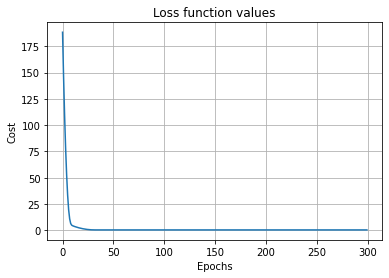

In [19]:
# Load data from the text file
with open("txtFilesAutoencoder_V6/losseslist_avg_Train_v11.txt", "r") as file:
    data = [float(line.strip()) for line in file]

# Plot the data
plt.plot(data)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Loss function values")
plt.grid(True)
plt.show()

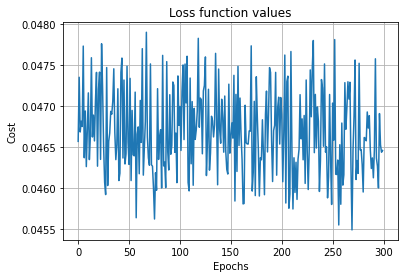

In [20]:
# Load data from the text file
with open("txtFilesAutoencoder_V6/losses_avg_Val_V11.txt", "r") as file:
    data = [float(line.strip()) for line in file]
# Plot the data
plt.plot(data)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Loss function values")
plt.grid(True)
plt.show()

Once the model has been trained we will show the results:

The below function is used for formatting the image to make it able to be showed.

In [21]:
#Utility functions to un-normalize and display an image
def imshow(img):
    # img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0))) 

## Updating the weights of the Encoder part

In [22]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()        
         # 15, 3, 160, 160.  Batch size, input channels, shape of the image.
        input_channels = 3              # number of channels of the input image
        output_channels = 55           # ~= 110/2. Shape of the input image divided by 2 approximately. 
        kernel_size = 9
        padding_val = 1
        stride_val = 5

        
        output_channels_layer2 = output_channels*2+5
        output_channels_layer3 = output_channels_layer2*2
        
        self.conv2d_1 = nn.Conv2d(input_channels, output_channels, kernel_size, stride=stride_val, padding=padding_val)
        self.conv2d_2 = nn.Conv2d(output_channels, output_channels_layer2, kernel_size, stride=stride_val, padding=padding_val)
        self.conv2d_3 = nn.Conv2d(output_channels_layer2, output_channels_layer3, 5)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()

        # self.fc = nn.Linear(output_channels_layer3, output_channels_layer3)

    def forward(self, x, flag = False):
        if flag:
            print("The FORWARD function is starting")

            print("The ENCODER part is executing")
            output = x
            print("The input image shape is: ", output.shape)
            output = self.conv2d_1(output)
            print("self.conv2d_1 shape is: ", output.shape)
            output = self.relu1(output)
            output = self.conv2d_2(output)
            print("self.conv2d_2 shape is: ", output.shape)
            output = self.relu2(output)
            output = self.conv2d_3(output)
            print("self.conv2d_3 shape is: ", output.shape)

            # # print("The LINEAR and TANH layers")
            # output = output.view(output.size(0), -1)
            # print("output.view shape is: ", output.shape)
            # output = self.fc(output)
            # print("self.fc shape is: ", output.shape)
            # print("Finish the FORWARD function")

        else:
            # print("The FORWARD function is starting")

            # print("The ENCODER part is executing")
            output = x
            # print("The input image shape is: ", output.shape)
            output = self.conv2d_1(output)
            # print("self.conv2d_1 shape is: ", output.shape)
            output = self.relu1(output)
            output = self.conv2d_2(output)
            # print("self.conv2d_2 shape is: ", output.shape)
            output = self.relu2(output)
            output = self.conv2d_3(output)
            # print("self.conv2d_3 shape is: ", output.shape)

            # # print("The LINEAR and TANH layers")
            # output = output.view(output.size(0), -1)
            # # print("output.view shape is: ", output.shape)
            # output = self.fc(output)
            # # print("self.fc shape is: ", output.shape)

        return output
    
    def show_modules(self):
        print("This is the show modules function")
        i = 0
        for m in self.modules():
            print(m)
            print("i is: ", i)
            print("print the next module")
            i = i +1
            
    def show_one_layer_weights(self, index):
        print("This is the one layer show function")
        i = 0
        for name, m in self.named_modules():
        # for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                if i == index:
                    print("Layer name is:", name)
                    print("The weights are: ", m.weight)
                i = i +1                                 

In [23]:
model_encoder = Encoder()
model_encoder.to(device)

Encoder(
  (conv2d_1): Conv2d(3, 55, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
  (conv2d_2): Conv2d(55, 115, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
  (conv2d_3): Conv2d(115, 230, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (relu2): ReLU()
)

In [24]:
# Copy the layer weights from the base model to the target model
for target_layer, base_layer in zip(model_encoder.children(), model.children()):
    target_params = target_layer.parameters()
    base_params = base_layer.parameters()

    # Copy the weights from the base model to the target model
    for target_param, base_param in zip(target_params, base_params):
        target_param.data.copy_(base_param.data)

# Verify if the weights are successfully copied
for target_layer, base_layer in zip(model_encoder.children(), model.children()):
    target_params = target_layer.parameters()
    base_params = base_layer.parameters()

    for target_param, base_param in zip(target_params, base_params):
        if torch.allclose(target_param.data, base_param.data):
            print("Layer weights are successfully copied.")
        else:
            print("Error: Layer weights are not copied correctly.")


Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.


In [25]:
model_encoder.show_one_layer_weights(2)

This is the one layer show function
Layer name is: conv2d_3
The weights are:  Parameter containing:
tensor([[[[ 1.5015e-06,  2.8992e-05,  3.2438e-08,  6.8519e-06, -2.7262e-05],
          [ 8.6699e-06, -1.8551e-05,  1.3396e-05,  3.6266e-06,  4.0299e-05],
          [-1.1941e-05,  1.3548e-05, -3.9835e-06,  6.0610e-06, -5.6612e-06],
          [-4.1398e-06, -2.9542e-05,  1.3975e-05,  6.0355e-07, -3.1479e-05],
          [ 1.7661e-05, -1.4117e-06,  2.4545e-06,  1.2715e-05,  2.0290e-05]],

         [[ 1.6644e-05, -2.5363e-06,  2.6938e-05,  5.0533e-07, -6.9623e-06],
          [ 3.9734e-06,  1.2092e-05, -1.5039e-05,  1.3892e-05,  1.4031e-05],
          [-1.4128e-05,  6.3588e-06,  9.1983e-06, -7.5071e-06, -5.3515e-07],
          [ 3.1996e-06, -1.9150e-07, -2.3437e-05, -2.3166e-05,  1.3283e-06],
          [ 1.4087e-05,  1.3476e-05, -1.4079e-05, -1.1605e-05, -9.1167e-06]],

         [[ 2.8886e-05,  4.5521e-06,  1.0690e-05, -1.8182e-05,  9.1424e-07],
          [-3.5110e-06, -1.0384e-05, -5.7272e-06,

In [26]:
model.show_one_layer_weights(2)

This is the one layer show function
Layer name is: conv2d_3
The weights are:  Parameter containing:
tensor([[[[ 1.5015e-06,  2.8992e-05,  3.2438e-08,  6.8519e-06, -2.7262e-05],
          [ 8.6699e-06, -1.8551e-05,  1.3396e-05,  3.6266e-06,  4.0299e-05],
          [-1.1941e-05,  1.3548e-05, -3.9835e-06,  6.0610e-06, -5.6612e-06],
          [-4.1398e-06, -2.9542e-05,  1.3975e-05,  6.0355e-07, -3.1479e-05],
          [ 1.7661e-05, -1.4117e-06,  2.4545e-06,  1.2715e-05,  2.0290e-05]],

         [[ 1.6644e-05, -2.5363e-06,  2.6938e-05,  5.0533e-07, -6.9623e-06],
          [ 3.9734e-06,  1.2092e-05, -1.5039e-05,  1.3892e-05,  1.4031e-05],
          [-1.4128e-05,  6.3588e-06,  9.1983e-06, -7.5071e-06, -5.3515e-07],
          [ 3.1996e-06, -1.9150e-07, -2.3437e-05, -2.3166e-05,  1.3283e-06],
          [ 1.4087e-05,  1.3476e-05, -1.4079e-05, -1.1605e-05, -9.1167e-06]],

         [[ 2.8886e-05,  4.5521e-06,  1.0690e-05, -1.8182e-05,  9.1424e-07],
          [-3.5110e-06, -1.0384e-05, -5.7272e-06,

Above we see the parameters are the same, hence the weights updates has been successfully performed.

Check the usage of the "model_encoder" newtork in only one image.

In [27]:
num_epochs = 1
outputs = []
for epoch in range(num_epochs):
    for i, (img, _) in enumerate(dataloader):
        if i == 1:
            break
        img = img.to(device)
        single_img = img[0]
        imgs_croped = transforms.functional.crop(single_img.cuda(), TOP_CROP_POS, LEFT_CROP_POS, 160, 160)
        image_in_tensor = imgs_croped[None, :].cuda()
        print(image_in_tensor.shape)
        # Forward pass
        with torch.no_grad():
            recon = model_encoder(image_in_tensor,True)          # The entire batch of images is passed to the model
            recon = recon.view(recon.size(0), -1)

print("the shape of the output of the encoder model is: ", recon.shape)


torch.Size([1, 3, 160, 160])
The FORWARD function is starting
The ENCODER part is executing
The input image shape is:  torch.Size([1, 3, 160, 160])
self.conv2d_1 shape is:  torch.Size([1, 55, 31, 31])
self.conv2d_2 shape is:  torch.Size([1, 115, 5, 5])
self.conv2d_3 shape is:  torch.Size([1, 230, 1, 1])
the shape of the output of the encoder model is:  torch.Size([1, 230])


## Obtaining the KDE representation of the training set images

In [28]:
########################################################
# Calculate KDE using sklearn
from sklearn.neighbors import KernelDensity

#Get encoded output of input images = Latent space
# encoded_images = model_encoder(images)
encoded_images = []

for i in range(len(dataset)):
    X = dataset[i]
    image_in_tensor = X[0]
    imgs_croped = transforms.functional.crop(image_in_tensor.cuda(), TOP_CROP_POS, LEFT_CROP_POS, 160, 160)
    image_in_tensor = imgs_croped[None, :].cuda()
    with torch.no_grad():
        # print(image_in_tensor.shape)
        Y = model_encoder(image_in_tensor)  # should be same as X
        Y = Y.view(Y.size(0), -1)
    encoded_images.append(Y)


c:\Users\alexj\.conda\envs\tfm_3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [29]:
print(len(encoded_images))
print(type(encoded_images))
print(type(encoded_images[0]))

295
<class 'list'>
<class 'torch.Tensor'>


See that it is 295 length because it corresponds to all the images that belong to the training dataset. 
 

Convert "encoded_images" to a np array

In [30]:
np_encoded_images = []
for i in range (len(encoded_images)):
    # np_conversion = encoded_images[i].detach().numpy()        # If not using GPU
    np_conversion = encoded_images[i].cpu().detach().numpy()    # If using GPU
    np_encoded_images.append(np_conversion)
np_encoded_images = np.array(np_encoded_images)
print(type(np_encoded_images))

<class 'numpy.ndarray'>


In [31]:
print(np_encoded_images.shape)

(295, 1, 230)


Make sure to flatten the encoded images

In [32]:
np_encoded_images_vector = np.squeeze(np_encoded_images)
print(np_encoded_images_vector.shape)

(295, 230)


As here we flatten the feature vectors until reaching the point of having per each image, one feature vector of 230 lenght, that is, a matrix of (num of images, num of elements in the feature vector), the following plot of the histogram is not expected to demonstrate something useful or that we could understand. 

(array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0., 295.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([-5.26283366e-05, -4.25587496e-05, -3.24891662e-05, -2.24195792e-05,
        -1.23499931e-05, -2.28040699e-06,  7.78917911e-06,  1.78587652e-05,
         2.79283504e-05,  3.79979356e-05,  4.80675226e-05]),
 <a list of 230 BarContainer objects>)

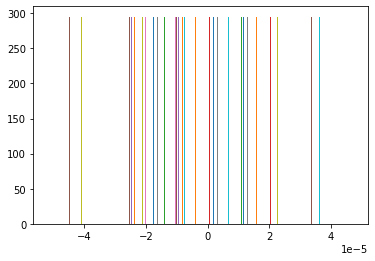

In [33]:
plt.hist(np_encoded_images_vector, bins=10)

Obtaining the best bandwidth value

In [34]:
from sklearn.model_selection import GridSearchCV
bandwidth_values = np.array([0.0000001,0.000001,0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.001, 0.005, 0.01, 0.1])
kde = KernelDensity(kernel='gaussian')
grid = GridSearchCV(kde, {'bandwidth': bandwidth_values})
grid.fit(np_encoded_images_vector)

GridSearchCV(estimator=KernelDensity(),
             param_grid={'bandwidth': array([1.e-07, 1.e-06, 1.e-05, 5.e-05, 1.e-04, 5.e-04, 1.e-03, 1.e-03,
       5.e-03, 1.e-02, 1.e-01])})

In [35]:
best_bandwidth = grid.best_params_['bandwidth']
print(best_bandwidth)

1e-07


In [36]:
kde = KernelDensity(kernel='gaussian', bandwidth=best_bandwidth).fit(np_encoded_images_vector)

In [37]:
density_vals = kde.score_samples(np_encoded_images_vector)
print(density_vals)


[3495.80613626 3495.80613617 3495.80613614 3495.80613617 3495.80613615
 3495.80613626 3495.80613628 3495.80613628 3495.80613626 3495.80613628
 3495.80613627 3495.80613627 3495.8061362  3495.80613615 3495.80613614
 3495.80613625 3495.80613628 3495.80613628 3495.80613627 3495.80613627
 3495.80613627 3495.80613627 3495.80613627 3495.80613627 3495.80613617
 3495.80613619 3495.8061362  3495.80613628 3495.80613628 3495.80613628
 3495.80613629 3495.80613628 3495.80613627 3495.80613624 3495.8061357
 3495.80613573 3495.80613569 3495.80613616 3495.80613625 3495.80613621
 3495.80613611 3495.80613623 3495.80613608 3495.80613601 3495.80613597
 3495.80613582 3495.80613577 3495.8061357  3495.80613565 3495.80613619
 3495.80613615 3495.80613624 3495.80613624 3495.80613624 3495.80613625
 3495.80613624 3495.80613626 3495.80613625 3495.80613621 3495.80613616
 3495.80613618 3495.80613625 3495.80613628 3495.80613627 3495.80613626
 3495.80613626 3495.80613618 3495.80613619 3495.80613617 3495.80613613
 3495.8

In [38]:
print(density_vals.shape)

(295,)


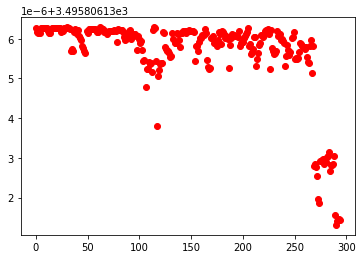

In [39]:
plt.scatter(np.arange(len(density_vals)), density_vals, c='red')

In [40]:
average_density = np.mean(density_vals)
stdev_density = np.std(density_vals)
print("The avg of the density values is: ", average_density)
print("The stdev_density of the density values is: ", stdev_density)

The avg of the density values is:  3495.806135649773
The stdev_density of the density values is:  1.0524948855204307e-06


# Function to check if an image contains anomalies

Based on the previously found score of the KDE samples, its average and its standard deviation values, it can be built a function that maps the KDE scores to a probability value of an image being considered as an anomaly or not.

If the a given KDE score is outside the range of the standard deviation sum and subtraction to the average values, then that KDE score has more than 50% chance to be considered as an anomaly image.

In [41]:
def ranges_mapper(value, leftMin, leftMax, rightMin, rightMax):
    # if(value>leftMax):
    #     return rightMax
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)

In [42]:
def map_kde2prob_list(input_list):
    threshold_NOanomaly = average_density          # The mean of the density values corresponding to the non-anomaly images
    std_dev_NOanomaly = stdev_density            # The std deviation of the density values corresponding to the non-anomaly images

    prob_score_list = []

    for i in range (len(input_list)):
        score_NOanomaly = input_list[i] - threshold_NOanomaly

        perc_NOanomaly = ranges_mapper(abs(score_NOanomaly), 0, std_dev_NOanomaly, 0, 50)
        if perc_NOanomaly<0:
            perc_NOanomaly = 0
        if perc_NOanomaly>100:
            perc_NOanomaly = 100
        prob_score_list.append(perc_NOanomaly)
    return prob_score_list

In [43]:
def map_kde2prob(value):
    threshold_NOanomaly = average_density          # The mean of the density values corresponding to the non-anomaly images
    std_dev_NOanomaly = stdev_density            # The std deviation of the density values corresponding to the non-anomaly images

    score_NOanomaly = value - threshold_NOanomaly

    perc_NOanomaly = ranges_mapper(abs(score_NOanomaly), 0, std_dev_NOanomaly, 0, 50)
    if perc_NOanomaly<0:
        perc_NOanomaly = 0
    if perc_NOanomaly>100:
        perc_NOanomaly = 100
    
    prob_score = perc_NOanomaly
    return prob_score

In [44]:
print(map_kde2prob(average_density+stdev_density))

50.000005841339835


In [45]:
def computePred(kde_value):
    pred = 0
    prob_anomaly = map_kde2prob(kde_value)/100
    if prob_anomaly > 0.5:
        pred = 1
    return pred

In [46]:
print("The prob of the kde value of being anomaly image is: ", map_kde2prob(average_density+stdev_density))
print("Given the probability, it is actually predicted as:", computePred(average_density+stdev_density))

The prob of the kde value of being anomaly image is:  50.000005841339835
Given the probability, it is actually predicted as: 1


# Validating the performance of the model with KDE score directly

We will use the validation data set to find the best threshold value for predicting an image as anomaly or non-anomaly.

In [47]:
val_dir = '../../Images/june5Night/Validation'      #This is for the home laptop
# test_dir = '../../../Images/BottleStoodUp_atNight/Evaluation'      #This is for the home laptop
# test_dir = '../../../../BottleStoodUp_atNight/Evaluation'      #This is for the work laptop
transform_characteristics = transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize(255),
                                                transforms.CenterCrop(224)])

dataset_val = datasets.ImageFolder(val_dir, transform=transform_characteristics)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=15, shuffle=True)
classes = ('non-anomaly','anomaly')

In [48]:
y_true = []
encoded_images = []

for i in range(len(dataset_val)):
    X = dataset_val[i]
    image_in_tensor = X[0]
    imgs_croped = transforms.functional.crop(image_in_tensor.cuda(), TOP_CROP_POS, LEFT_CROP_POS, 160, 160)
    image_in_tensor = imgs_croped[None, :].cuda()   # If using the GPU
    # image_in_tensor = image_in_tensor[None, :]   # If NO GPU
    ground_truth = X[1]

    with torch.no_grad():
        Y = model_encoder(image_in_tensor)  # should be same as X
        Y = Y.view(Y.size(0), -1)
    encoded_images.append(Y)
    y_true.append(ground_truth) # Save Truth
print("The ground truth labels are: ", y_true)
print("The encoded_images len is: ", len(encoded_images)) 



c:\Users\alexj\.conda\envs\tfm_3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


The ground truth labels are:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
The encoded_images len is:  30


In [49]:
np_encoded_images = []
for i in range (len(encoded_images)):
    # np_conversion = encoded_images[i].detach().numpy()        # If not using GPU
    np_conversion = encoded_images[i].cpu().detach().numpy()    # If using GPU
    np_encoded_images.append(np_conversion)
np_encoded_images = np.array(np_encoded_images)
print(np_encoded_images.shape)
np_encoded_images_vector = np.squeeze(np_encoded_images)
print(np_encoded_images_vector.shape)

(30, 1, 230)
(30, 230)


In [50]:
density_validation = kde.score_samples(np_encoded_images_vector)
print(density_validation.shape)

(30,)


In [51]:
print(density_validation)

[3495.80613614 3495.80613618 3495.80613624 3495.80613615 3495.80613622
 3495.80613622 3495.80613613 3495.80613619 3495.80613486 3495.80613608
 3495.80613579 3495.80613585 3495.80613599 3495.80613577 3495.80613572
 3495.80613619 3495.80613615 3495.8061321  3495.80613295 3495.80613296
 3495.80613408 3495.80613516 3495.80613187 3495.80613459 3495.80613439
 3495.80613438 3495.80613558 3495.80613354 3495.80613328 3495.80613109]


Let's compute the ROC and AUC score out of directly the KDE scores obtained from the images of the validation data set.

In [52]:
from sklearn import metrics
print('AUC = ', metrics.roc_auc_score(y_true, density_validation))

AUC =  0.13


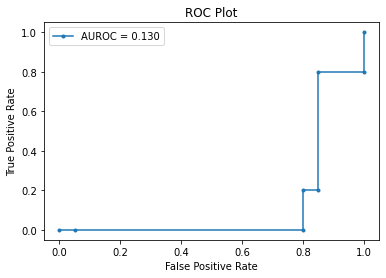

In [53]:
fpr, tpr, thresholds = metrics.roc_curve(y_true, density_validation)
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % metrics.roc_auc_score(y_true, density_validation))
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

In [54]:
print("The fpr is: ", fpr)
print("The tpr is: ", tpr)
print("The thresholds are: ", thresholds)

The fpr is:  [0.   0.05 0.8  0.8  0.85 0.85 1.   1.  ]
The tpr is:  [0.  0.  0.  0.2 0.2 0.8 0.8 1. ]
The thresholds are:  [3496.80613624 3495.80613624 3495.80613572 3495.80613516 3495.80613486
 3495.80613328 3495.8061321  3495.80613109]


The best threshold value for this is: 3495.806133288, let's asses this.

In [55]:
def pred_label_onProb(probs_list, prob_threshold):
    pred_based_onProb = []
    for i in range (len(probs_list)):
        if probs_list[i] > prob_threshold:
            prediction = 1                          ## Stands for classifiaction of anomaly bottle
        else:
            prediction = 0
        pred_based_onProb.append(prediction)
    return pred_based_onProb

In [56]:
# from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, SpecificityAtSensitivity
from sklearn.metrics import confusion_matrix

In [57]:
best_threshold_approach1 =3495.80613328 

In [58]:
conf_matrix = confusion_matrix(y_true, pred_label_onProb(density_validation, best_threshold_approach1))
print(conf_matrix)
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)
print("Using the threshold = ", best_threshold_approach1)

[[ 3 17]
 [ 2  8]]
The FPR values are:  0.85
The TPR values are:  0.8
Using the threshold =  3495.80613328


# Validating the performance of the model with the mapping of the density score to a probability value

In [59]:
probs_list = map_kde2prob_list(density_validation)
print("The probability list is: ", probs_list)
print("The ground truth labels are: ", y_true)

The probability list is:  [23.296657968834825, 24.95756322889057, 28.248913089593124, 23.91762335468642, 27.166565928566445, 27.26628678234779, 22.909310718336663, 25.872333556558957, 37.4115010431087, 20.389587689384992, 6.483864603110119, 9.355591876323754, 16.396346464003955, 5.6674757243412675, 3.2379896984755323, 25.83854598825003, 23.713104870555572, 100, 100, 100, 74.48974951030081, 23.41141472257973, 100, 50.382773191274374, 59.70639217687101, 60.415261408917644, 3.154147273535022, 100, 100, 100]
The ground truth labels are:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [60]:
from sklearn import metrics
print('AUC = ', metrics.roc_auc_score(y_true, probs_list))

AUC =  0.75


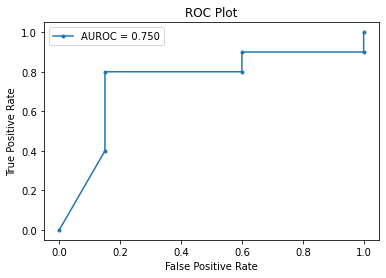

In [61]:
fpr, tpr, thresholds = metrics.roc_curve(y_true, probs_list)
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % metrics.roc_auc_score(y_true, probs_list))
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

In [62]:
print("The fpr is: ", fpr)
print("The tpr is: ", tpr)
print("The thresholds are: ", thresholds)

The fpr is:  [0.   0.15 0.15 0.6  0.6  1.   1.  ]
The tpr is:  [0.  0.4 0.8 0.8 0.9 0.9 1. ]
The thresholds are:  [101.         100.          50.38277319  23.71310487  23.41141472
   3.2379897    3.15414727]


In [63]:
best_threshold_approach2 = 23.4114147

The best threshold in terms of FPR and TPR is 23.4114147. Let's asses that.

In [64]:
conf_matrix = confusion_matrix(y_true, pred_label_onProb(probs_list, best_threshold_approach2))
print(conf_matrix)
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)
print("Using the threshold = ", best_threshold_approach2)

[[ 8 12]
 [ 1  9]]
The FPR values are:  0.6
The TPR values are:  0.9
Using the threshold =  23.4114147


# Evaluating the model. With the threhsold value of the direct density score

In [65]:
test_dir = '../../Images/june5Night/Evaluation'      #This is for the home laptop
# test_dir = '../../../Images/BottleStoodUp_atNight/Evaluation'      #This is for the home laptop
# test_dir = '../../../../BottleStoodUp_atNight/Evaluation'      #This is for the work laptop
transform_characteristics = transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize(255),
                                                transforms.CenterCrop(224)])

dataset_test = datasets.ImageFolder(test_dir, transform=transform_characteristics)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=15, shuffle=True)
classes = ('non-anomaly','anomaly')

In [66]:
y_true = []
densityScore_lst = []

for i in range(len(dataset_test)):
    X = dataset_test[i]
    image_in_tensor = X[0]
    imgs_croped = transforms.functional.crop(image_in_tensor.cuda(), TOP_CROP_POS, LEFT_CROP_POS, 160, 160)
    image_in_tensor = imgs_croped[None, :].cuda()   # If using the GPU
    # image_in_tensor = image_in_tensor[None, :]   # If NO GPU
    ground_truth = X[1]

    with torch.no_grad():
        Y = model_encoder(image_in_tensor)  # should be same as X
        Y = Y.view(Y.size(0), -1)
    np_converted_encoded_img = Y.cpu().detach().numpy()
    # print(np_converted_encoded_img.shape)
    density_score = kde.score_samples(np_converted_encoded_img)
    # print(density_score)
    densityScore_lst.append(density_score)

    y_true.append(ground_truth) # Save Truth
print("The density score list is: ", densityScore_lst)
print("The ground truth labels are: ", y_true)

c:\Users\alexj\.conda\envs\tfm_3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
c:\Users\alexj\.conda\envs\tfm_3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to b

The density score list is:  [array([3495.80613615]), array([3495.80613628]), array([3495.80613628]), array([3495.80613607]), array([3495.80613627]), array([3495.80613629]), array([3495.80613593]), array([3495.80613589]), array([3495.80613535]), array([3495.80613525]), array([3495.80613321]), array([3495.80613595]), array([3495.80613565]), array([3495.8061361]), array([3495.80613611]), array([3495.80613582]), array([3495.80613545]), array([3495.80613249]), array([3495.80613154]), array([3495.80613133]), array([3495.80613528]), array([3495.80613401]), array([3495.80613496]), array([3495.806135]), array([3495.80613472]), array([3495.80613473]), array([3495.80613554]), array([3495.80613532]), array([3495.80613429]), array([3495.80613332])]
The ground truth labels are:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


c:\Users\alexj\.conda\envs\tfm_3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
c:\Users\alexj\.conda\envs\tfm_3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to b

In [67]:
conf_matrix = confusion_matrix(y_true, pred_label_onProb(densityScore_lst, best_threshold_approach1))
print(conf_matrix)
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)
print("Using the threshold = ", best_threshold_approach1)

[[ 4 16]
 [ 0 10]]
The FPR values are:  0.8
The TPR values are:  1.0
Using the threshold =  3495.80613328


In [68]:
y_pred = pred_label_onProb(densityScore_lst, best_threshold_approach1)
print("The groudn truth is: ", y_true)
print("The predicted label is: ", y_pred)

The groudn truth is:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
The predicted label is:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


# Applying evaluation metrics to these results

## Computing the confusion matrix

In [69]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

In [70]:
conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)

[[ 4 16]
 [ 0 10]]


Text(0.5, 15.0, 'Predicted label')

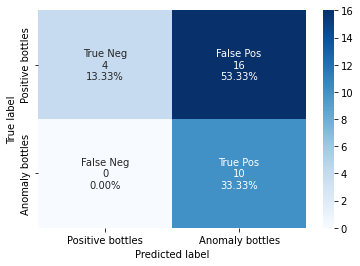

In [71]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]        #To print the group names as well 

labels = np.asarray(labels).reshape(2,2)
categories = ['Positive bottles', 'Anomaly bottles']
sn.heatmap(conf_matrix, annot=labels, fmt='', xticklabels=categories,yticklabels=categories, cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [72]:
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)

The FPR values are:  0.8
The TPR values are:  1.0


## Precision metric

Precision = True positives / (True positives + False positives).

Answers the question: Which proportion of positive predictions is actually right?

In [73]:
precision = _tp/(_tp+_fp)
print("The precision is: ", precision)


The precision is:  0.38461538461538464


## Recall metric

Recall = TruePositives / (TruePositives + FalseNegatives)

This metric is also called "sensitiviy" and TPR "True Positive Rate". It responds how good is the model at catching YESes?

In [74]:
recall = _tp/(_tp+_fn)
print("The recall is: ", recall)

The recall is:  1.0


## Specificity

Specificity = True negatives / (True negatives + false positives)

The specificity metric is the opposite as sensitivity, it tells us how good is the model at catching NOes. It measures the proportion of actual negatives that are correctly identified as such.

In [75]:
spec = _tn/(_tn+_fp)
print("The specificity is: ", spec)

The specificity is:  0.2


## Accuracy

Accuracy = (True negatives + True positives) / (True positives + True negatives + False positives + False negatives)

In [76]:
acc = (_tn+_tp)/(_tn+_tp +_fp + _fn)
print("The accuracy is: ", acc)

The accuracy is:  0.4666666666666667


## The ROC curve

In [77]:
from sklearn.metrics import roc_curve, roc_auc_score


Rather than the prediction of each sample (0 or 1 values) we need the probability of the samples to be predicted as an anomaly image. Hence, we compute this probability

In [78]:
auc_score = roc_auc_score(y_true, densityScore_lst)
print('AUROC = %.3f' % (auc_score))
fpr, tpr, thresholds = roc_curve(y_true, densityScore_lst)
print("The fpr is: ", fpr)
print("The tpr is: ", tpr)
print("The thresholds are: ", thresholds)

AUROC = 0.225
The fpr is:  [0.   0.05 0.65 0.65 0.75 0.75 0.8  0.8  1.  ]
The tpr is:  [0.  0.  0.  0.1 0.1 0.3 0.3 1.  1. ]
The thresholds are:  [3496.80613629 3495.80613629 3495.80613565 3495.80613554 3495.80613535
 3495.80613528 3495.80613525 3495.80613332 3495.80613133]


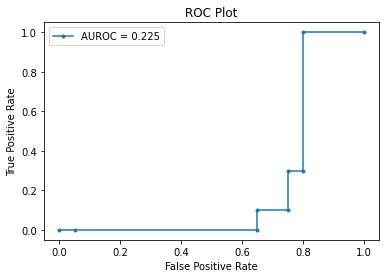

In [79]:
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % auc_score)
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

# Evaluating the model. With the threhsold value computed from a probability value upon the desnity scores

In [80]:
probs_list = map_kde2prob_list(densityScore_lst)
print("The probability list is: ", probs_list)
print("The ground truth labels are: ", y_true)

The probability list is:  [23.534121492397333, 29.966094957989515, 29.719147583731598, 20.124471936004433, 29.50492921585989, 30.34348308509227, 13.492106217449566, 11.428644980495728, 14.248934785586881, 18.8741374788331, 100, 14.284688254609437, 0.19162131131727186, 21.167609099281297, 21.83307729249632, 8.099510940143356, 9.676962634740411, 100, 100, 100, 17.58431218095286, 77.77904705707155, 32.53673697575458, 30.71961822053139, 43.94135908159588, 43.555135202934075, 4.992307647385384, 15.466756269417461, 64.62207290303404, 100]
The ground truth labels are:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [81]:
conf_matrix = confusion_matrix(y_true, pred_label_onProb(probs_list, best_threshold_approach2))
print(conf_matrix)
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)
print("Using the threshold = ", best_threshold_approach2)

[[11  9]
 [ 3  7]]
The FPR values are:  0.45
The TPR values are:  0.7
Using the threshold =  23.4114147


In [82]:
y_pred = pred_label_onProb(probs_list, best_threshold_approach2)
print("The groudn truth is: ", y_true)
print("The predicted label is: ", y_pred)

The groudn truth is:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
The predicted label is:  [1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1]


# Applying evaluation metrics to these results

## Computing the confusion matrix

In [83]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

In [84]:
conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)

[[11  9]
 [ 3  7]]


Text(0.5, 15.0, 'Predicted label')

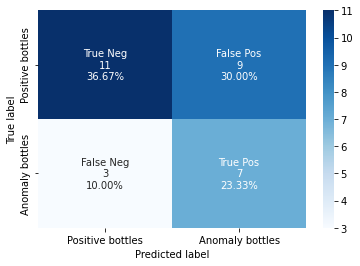

In [85]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]        #To print the group names as well 

labels = np.asarray(labels).reshape(2,2)
categories = ['Positive bottles', 'Anomaly bottles']
sn.heatmap(conf_matrix, annot=labels, fmt='', xticklabels=categories,yticklabels=categories, cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [86]:
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)

The FPR values are:  0.45
The TPR values are:  0.7


## Precision metric

Precision = True positives / (True positives + False positives).

Answers the question: Which proportion of positive predictions is actually right?

In [87]:
precision = _tp/(_tp+_fp)
print("The precision is: ", precision)


The precision is:  0.4375


## Recall metric

Recall = TruePositives / (TruePositives + FalseNegatives)

This metric is also called "sensitiviy" and TPR "True Positive Rate". It responds how good is the model at catching YESes?

In [88]:
recall = _tp/(_tp+_fn)
print("The recall is: ", recall)

The recall is:  0.7


## Specificity

Specificity = True negatives / (True negatives + false positives)

The specificity metric is the opposite as sensitivity, it tells us how good is the model at catching NOes. It measures the proportion of actual negatives that are correctly identified as such.

In [89]:
spec = _tn/(_tn+_fp)
print("The specificity is: ", spec)

The specificity is:  0.55


## Accuracy

Accuracy = (True negatives + True positives) / (True positives + True negatives + False positives + False negatives)

In [90]:
acc = (_tn+_tp)/(_tn+_tp +_fp + _fn)
print("The accuracy is: ", acc)

The accuracy is:  0.6


## The ROC curve

In [91]:
from sklearn.metrics import roc_curve, roc_auc_score


Rather than the prediction of each sample (0 or 1 values) we need the probability of the samples to be predicted as an anomaly image. Hence, we compute this probability

In [92]:
auc_score = roc_auc_score(y_true, probs_list)
print('AUROC = %.3f' % (auc_score))
fpr, tpr, thresholds = roc_curve(y_true, probs_list)
print("The fpr is: ", fpr)
print("The tpr is: ", tpr)
print("The thresholds are: ", thresholds)

AUROC = 0.645
The fpr is:  [0.   0.2  0.2  0.65 0.65 0.95 0.95 1.  ]
The tpr is:  [0.  0.1 0.7 0.7 0.9 0.9 1.  1. ]
The thresholds are:  [101.         100.          30.71961822  18.87413748  15.46675627
   8.09951094   4.99230765   0.19162131]


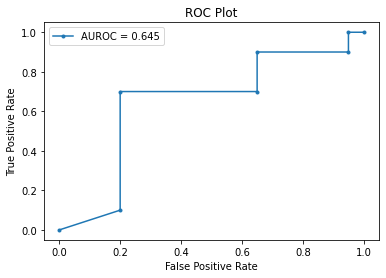

In [93]:
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % auc_score)
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()